In [2]:
import sys 
import os
root_dir = os.getcwd()
sys.path.append(root_dir)

In [3]:
from utils.graphviz import draw_dot, trace

In [3]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2-4*x+5

In [5]:
f(3.0)

20.0

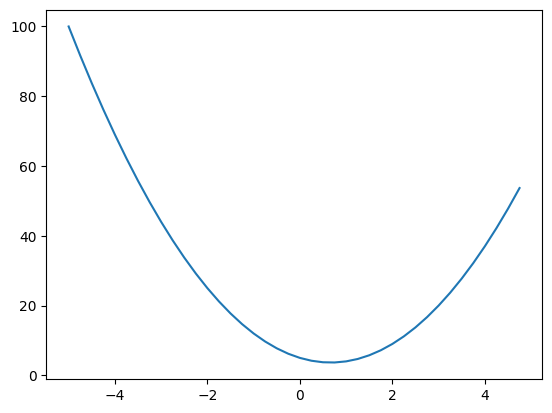

In [6]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys);

What is the derivative of this expression at any value of $x$ ?  

Neural network is super complex and noone would symbolically calculate the derivative in a neural network.


Derivative means the slope, i.e., what happens to the expression when we bump up $x$ by a small margin? 

In [7]:
h = 0.000001
x = 3.0 
(f(x+h) - f(x)) / h # rise over run, since we use approximate number for h we get approximately 14 

14.000003002223593

If we calculate symbolically we would get $6x - 4$ at 3 = 14 so it is correct

In [8]:
# lets get more complex 

a = 2.0 
b = -3.0
c = 10.0 
d = a*b +c
print(d)

4.0


lets bump each input (a,b,c) one by one and see how they affect the output

In [ ]:
h = 0.0001 
a = 2.0 
b = -3.0
c = 10.0 


d1 = a*b+c
b +=h
d2 = a*b +c

print(f'{d1=}  {d2=}')
print('slope', (d2-d1)/h)

## Build Value for NN
Neural networks are huge and complex. 
So we need some structure to keep track of the expressions.

We will Value as the first building block.

In [134]:
class Value:
    
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0 # Initially it is zero because we assume no effect
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        
    def __repr__(self):
        return f"Value(data={self.data},label={self.label})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        
        out = Value(self.data + other.data,(self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self,other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def tanh(self):
        n = self.data
        n_ = math.exp(2*n)
        t = (n_ - 1) / (n_ + 1)
        out = Value(t,(self,),'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t,(self,),'exp')
        
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
         
        return out
    
    
    def __truediv__(self,other):
        return self * (other ** -1)
    
    def __pow__(self,other:int|float):
        assert isinstance(other, (int,float)) , "only float or int is supported"
        x = self.data
        t = x ** other
        out = Value(t, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * other * (self.data ** (other-1))
            
        out._backward = _backward
        
        return out
    
        
    def backward(self):
        
        #build the DAG 
        topo = []
        visited = set()
        def build_topo(v):
            if v in visited:return
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        # call the backward on each Value node
        for node in reversed(topo):
            node._backward()

In [25]:
a = Value(2.0,label = 'a')
c = a + 1

In [26]:
a = Value(2.0,label = 'a')
c = 1 * a
c

Value(data=2.0,label=)

In [ ]:
a = Value(2.0,label = 'a')
b = Value(-3.0, label = 'b')
e = a * b; e.label='e'

c = Value(10.0,label='c')

d = e + c; d.label='d'
# equal to a.__mul__(b).__add__(c)

f = Value(-2, label = 'f')

L = d*f ; L.label = 'L'
L

Now we need is the connective tissue that connects all these elements.  
We need to keep track of what values produce what values.

Adding the `_children` and `_op` to tell each node how they are made.

In [ ]:
d._op

## Visualize the Computation Graph
We want a way to nicely visualize the expression graphs for us.

In [ ]:
draw_dot(d)

Note that our implementation has extra op nodes for better visualization.

They are not necessarily nodes on the computation (e.g., Value objects)

In [ ]:
draw_dot(L)

## Derivative and Chain Rule

We will find the derivative of $L$ is respect to the weights of the network.

Some parameters are the data and some are weights. Data is fixed, we are focusing on the derivatives with respect to the weights.

Next, we add the $\_grad$ variable to maintain the gradient (derivative) of $L$ with respect to that variable.

Initially grad is zero which means we assume no effect on output.

In [ ]:
draw_dot(L)

Lets derive the gradients for all variables manually.

In [ ]:
# function to bump each variable without changing the global scope
def lol():
    h = 0.0001
    
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    e = a * b; e.label='e'
    
    c = Value(10.0,label='c')
    d = e + c; d.label='d'
    
    # equal to a.__mul__(b).__add__(c)
    f = Value(-2, label = 'f')
    L = d*f ; L.label = 'L'
    L1 = L.data
    
    
    a = Value(2.0+h,label = 'a')
    b = Value(-3.0, label = 'b')
    e = a * b; e.label='e'
    c = Value(10.0,label='c')

    d = e + c; d.label='d'
    
    # equal to a.__mul__(b).__add__(c)
    f = Value(-2, label = 'f')
    L = d*f ; L.label = 'L'
    L2 = L.data
    
    print(f"{L1=} {L2=}  slope: {(L2-L1)/h}")

In [ ]:
lol()

Then we can manually add the _grad values for each node 

In [ ]:
L.grad = 1.0
f.grad = 4.
d.grad = -2

In [ ]:
draw_dot(L)

In [ ]:
# Most important 
# Chain rule
c.grad = -2
e.grad = -2

In [ ]:
# Finally the first layer
"""
dL/da => dL/dd * dd/de * de/da
      => -2 * 1 * -3 =6
      
same for b as well
"""
a.grad = 6
b.grad = -4

Lets manually check all these values using `lol()`

In [ ]:
draw_dot(L)

##### See affect of gradient in action

In [ ]:
# If we want to increase L we should go in the direction of the gradient

a.data +=0.01 * a.grad
b.data +=0.01 * b.grad

c.data +=0.01 * c.grad
f.data +=0.01 * f.grad

# forward pass
e = a * b 
d = e + c
L_new = d * f
print(L_new.data) #increase compared to L 

## Neuron discussion

Backpropagate through a neuron

- Hidden and fully-connected layers
- Biological neurons are similar
- Synapses have one input each and there are multiple inputs to each neurons
- Bias is like the innate happiness
- Then we have an activation like tanh.

In [ ]:
from IPython.display import Image
Image(filename='../assets/neuron.jpeg')

In [ ]:
# Activation funciton
x = np.arange(-10,10,0.2)
y = np.tanh(x)
plt.plot(x,y); plt.grid();

Activation allows us to create a non-linear mapping from inputs to outputs.

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

In [ ]:
# All this graph is a one single Neuron
draw_dot(n)

We have to implement tanh because you can not express tanh only using + and * operators.

We can implement exponential operation and build on top of it.

We can create functions of arbitrary abstraction and combine them.

The only thing that matters is that we should be able to calculate that expression's gradient efficiently.

Adding `def tanh` to the Value class now.

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)

## Back propagation start

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0
"""
Next node is n

if  o = tanh(n) what is do/dn ? 

derivative of tanh(x) => 1 - tanh^2(x) which is quite nice to calculate
"""
1 - o.data **2

In [ ]:
n.grad = 0.5

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

w2.grad = 0.0 #x2xw2.grad  * x2.data
w1.grad = 1.0 #x1xw1.grad  * x1.data

In [ ]:
draw_dot(o)

# Manual grad -> Auto grad

Now we consider whether we can automate what we manually calculated for passing the gradients all the way down to the leaf notes.

Codify the recursive application of the chain rule.

We will implement `self._backward` next for this.

In [27]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


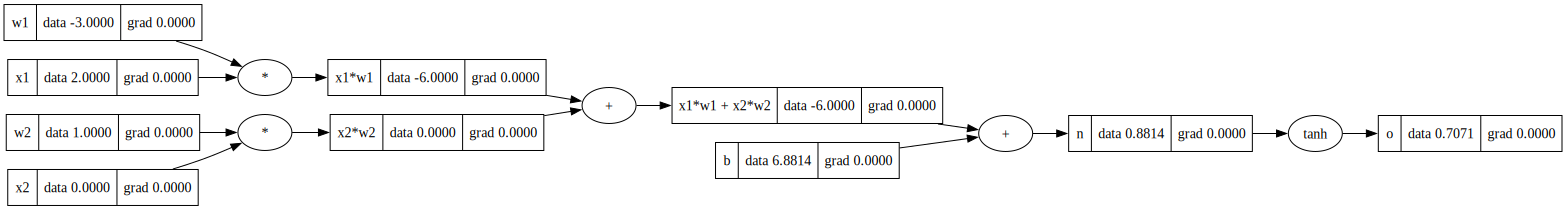

In [28]:
draw_dot(o)

In [29]:
o.backward()

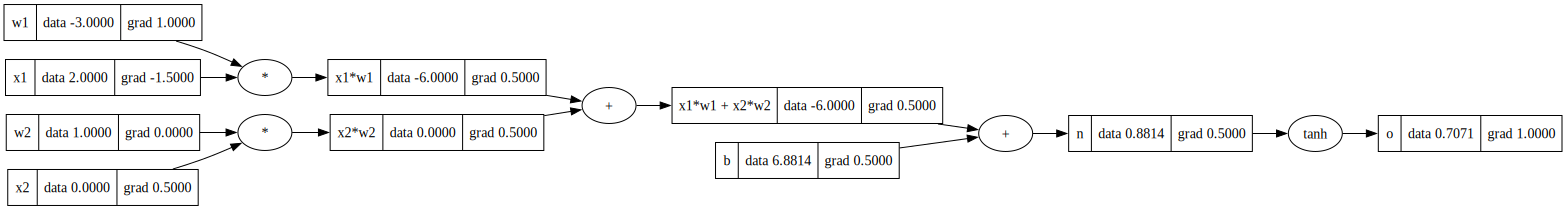

In [30]:
draw_dot(o)

In [18]:
# Now lets call backward function instead of manually updating the gradients
o.grad = 1.0
o._backward() # now we should see n.grad equal to 0.5 above

In [19]:
n._backward()

In [ ]:
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

So in above we got the same grads using the _backward()

###  Last Piece of the Puzzle
Automate calls to `backward()` in a recursive way.

We have to call backward according to topological sort.
Which means we call backward only if every node that's dependent to it have the backward() function called.



In [ ]:
# topological sort
def build_topo(o):
    topo = []
    visited = set()
    def helper(o):
        if o in visited:return
        visited.add(o)
        for child in o._prev:
            helper(child)
        topo.append(o)
    helper(o)
    return topo
topo = build_topo(o)

In [ ]:
for node in reversed(topo):
    print(node.label)

In [ ]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

In [ ]:
draw_dot(o)

## Finally hide the topo within Value class

Obviously, we don't want to manually calculate the topological sort and run the reversed backward for all our computation graphs.

Instead, now we build the actual `Value.backward()` that does this for us.



In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
draw_dot(o)

## Bug about a+a case

Within the backward function, if we set `other.grad = ...` instead of `+=` this will cause an issue.
Whenever a variable used twice in the computation graph this would override the previous grad accumulated.



### Adding more operations for tanh

Previously we implemented tanh as a complex operation. 
We can break tanh into its atomic operations.

Here we will implement `rmul` etc. for backward operations and `exp` and `pow` for supporting tanh.

Explain how `__mul__` works and why we need `__radd__` and `__rmul__` methods. 

In [31]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----

o.label = 'o'

In [32]:
o.backward()

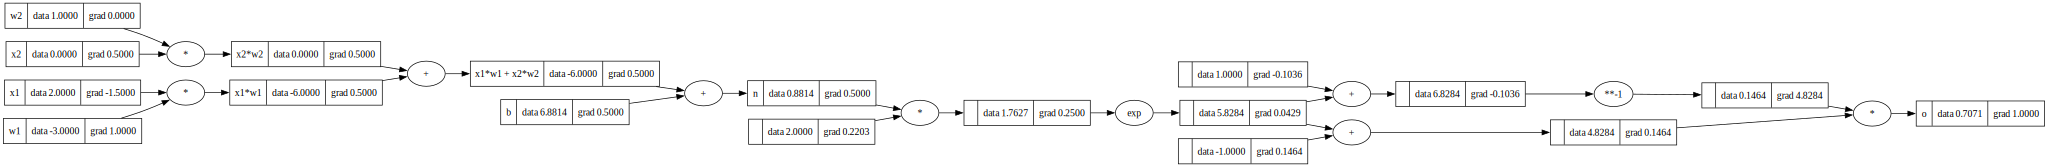

In [35]:
draw_dot(o)

# From Value -> Neuron -> Layer -> MLP

In [37]:
np.random.uniform(-1,1)

-0.7898665468044073

In [183]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(np.random.uniform(-1,1)) for i in range(nin)]
        self.b = Value(np.random.uniform(-1,1))
        
    
    def __call__(self,x):
        assert len(x) == len(self.w), f'{len(inp)} neq {len(self.w)}'
        act = sum([i*w_ for i,w_ in zip(x,self.w)],self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for n in range(nout)]
        
    def __call__(self,x):
        return [neuron(x) for neuron in self.neurons]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self,nin,nouts:list[int]):
        szs = [nin] + nouts
        self.layers = [Layer(sz1,sz2) for sz1,sz2 in zip(szs,szs[1:])]
        
    def __call__(self,x:list[int|float])-> Value | list[Value]:
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x)==1 else x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [184]:
n = Neuron(3)
inp = [1,2,3]
n(inp)

Value(data=0.3223625105470992,label=)

In [185]:
layer = Layer(3,4)

In [186]:
layer(inp)

[Value(data=-0.8091585340194912,label=),
 Value(data=0.8933680781143667,label=),
 Value(data=-0.9991354010722681,label=),
 Value(data=0.9950661805054423,label=)]

In [187]:
mlp = MLP(3,[4,4,1])

In [188]:
out = mlp([1,2,3])

In [176]:
out

Value(data=0.771855947027151,label=)

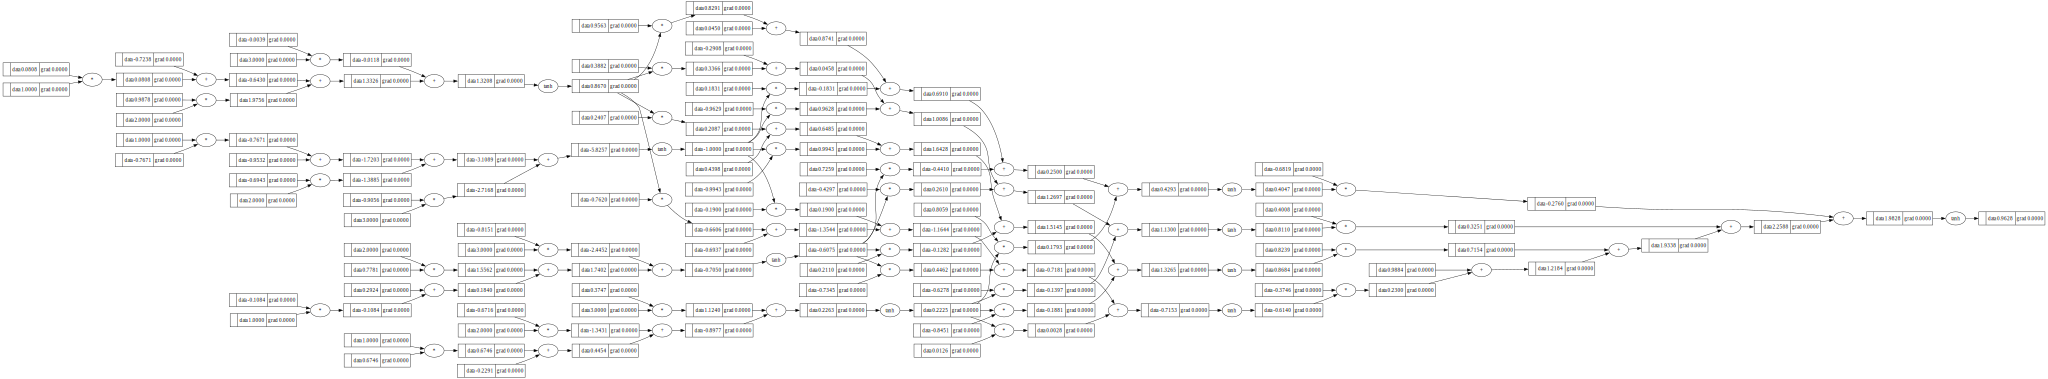

In [100]:
draw_dot(out)

## Training on a dataset

In [189]:
# tiny dataset 
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [190]:
ypreds = [mlp(x) for x in xs]
ypreds

[Value(data=0.6206596977738493,label=),
 Value(data=0.608750255821793,label=),
 Value(data=-0.034871117353409455,label=),
 Value(data=0.6724036573882907,label=)]

In [191]:
# single number: loss
loss = sum([(y_pred-y)**2 for y,y_pred in zip(ys,ypreds)])
loss

Value(data=3.7707695743109366,label=)

In [192]:
# magic!
loss.backward()

In [193]:
mlp.layers[0].neurons[0].w[0].data,mlp.layers[0].neurons[0].w[0].grad

(0.19672025265943271, 4.456124801117224)

## Train by iterating over the samples

First we need some tools for working efficiently. Let's implement the `self.parameters` variable.

In [195]:
len(mlp.parameters())

41

In [196]:
learning_rate = 0.01
for p in mlp.parameters():
    p.data += - learning_rate * p.grad

In [197]:
ypreds = [mlp(x) for x in xs]
ypreds

[Value(data=0.5433992224996526,label=),
 Value(data=0.4096902180656092,label=),
 Value(data=-0.21630672999206482,label=),
 Value(data=0.5951307601962004,label=)]

In [198]:
loss = sum([(y_pred-y)**2 for y,y_pred in zip(ys,ypreds)])
loss

Value(data=2.9738050237188243,label=)

## Now combine inside a for loop

In [204]:
mlp = MLP(3,[4,4,1])
epoch_size = 50

for epoch in range(epoch_size):
    
    # forward pass
    ypreds = [mlp(x) for x in xs]
    loss = sum([(y_pred-y)**2 for y,y_pred in zip(ys,ypreds)])
    
    #backward pass
    
    # flush the gradients
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    # update the model weights
    for p in mlp.parameters():
        p.data += - learning_rate * p.grad
    print(epoch,loss)

0 Value(data=3.721917285136539,label=)
1 Value(data=3.3330451924251223,label=)
2 Value(data=2.708955608181901,label=)
3 Value(data=2.0090188810024436,label=)
4 Value(data=1.3110063967460277,label=)
5 Value(data=0.7434281230735212,label=)
6 Value(data=0.4141991017089184,label=)
7 Value(data=0.24505169244492966,label=)
8 Value(data=0.14597019795976987,label=)
9 Value(data=0.08395606232750666,label=)
10 Value(data=0.04631207491562644,label=)
11 Value(data=0.02462985745842835,label=)
12 Value(data=0.012709211862735097,label=)
13 Value(data=0.0063938498728931155,label=)
14 Value(data=0.00314601602936348,label=)
15 Value(data=0.0015168728370352712,label=)
16 Value(data=0.0007175432210865093,label=)
17 Value(data=0.000333298629114852,label=)
18 Value(data=0.00015214073613999663,label=)
19 Value(data=6.83041596473446e-05,label=)
20 Value(data=3.0189055485962797e-05,label=)
21 Value(data=1.3149699861201963e-05,label=)
22 Value(data=5.651385740079149e-06,label=)
23 Value(data=2.399443547461424e-

In [205]:
ypreds 

[Value(data=0.9999999932688759,label=),
 Value(data=-0.9999999798796664,label=),
 Value(data=-0.9999999871627662,label=),
 Value(data=0.9999999904759618,label=)]

In [202]:
ys

[1.0, -1.0, -1.0, 1.0]

## To Do 

- Write the unittests as in [micrograd](https://github.com/karpathy/micrograd/blob/master/test/test_engine.py)
- Go over the demo as well inside the same repo